# Project #2
## Name: Joseph Josiwak

#### CS167: Machine Learning, Fall 2025

## __Put the Model in GPU mode__

We want to accelerate the training process using graphical processing unit (GPU). You need to enable it (click Settings --> Accelerator--> GPU T4 x2)

In [10]:
import torch
# check GPU (Kaggle will show "cuda" if GPU enabled in the notebook settings)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
import torch
import numpy as np
import random

# Set seeds for reproducibility
seed = 42  # you can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# If using CUDA:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU

In [13]:
# ============================================
# Step 1: imports and device (Kaggle version)
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import os
# ===========================================

In [14]:
# Step 2: dataset paths (Kaggle version)
# ============================================

base_dir   = "/kaggle/input/bfgmss-v1"      # <-- change this name to match your Kaggle dataset
train_dir  = os.path.join(base_dir, "bfgmss_v1/train")
test_dir   = os.path.join(base_dir, "bfgmss_v1/test")

# For AlexNet: normalize with ImageNet mean/std and resize to 227x227
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

dataset_labels = train_dataset.classes
number_of_classes = len(dataset_labels)
print("Classes:", dataset_labels)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [16]:
# ============================================
# Step 3: Multilayer Perceptron (MLP)
# ============================================

import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    """
    MLP for 150x150 RGB images.
    - Optional AdaptiveAvgPool2d to reduce dimensionality before flattening.
    - 2 hidden layers + final classifier.
    """
    def __init__(
        self,
        num_classes: int = 6
    ):
        super().__init__()

        # Input [B,3,150,150] -> [B,3,pooled_hw,pooled_hw]
        self.shrink = nn.AdaptiveAvgPool2d((32, 32))
        in_features = 3 * 32 * 32
      
        self.flatten = nn.Flatten()

        self.network_layers = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.shrink(x)     # optional spatial averaging
        x = self.flatten(x)    # [B, N]
        return self.network_layers(x)

In [17]:
# ============================================
# Step 4: training / testing loops 
# ============================================
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # forward + loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward + update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size
    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            running_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.append(pred.argmax(1).cpu())
            all_labels.append(y.cpu())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, conf_matrix

In [20]:
# ============================================
# Step 5: your fine-tuning block (Kaggle-ready)
# ============================================
mlp_model = SimpleMLP(number_of_classes)
mlp_model.to(device)
print(mlp_model)

learning_rate   = 1e-4
batch_size_val  = 32
epochs          = 30
loss_fn         = nn.CrossEntropyLoss()
optimizer       = optim.Adam(mlp_model.parameters(), lr=learning_rate)
softmax         = nn.Softmax(dim=1)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size_val,
    shuffle=True,
    num_workers=2,        # Kaggle: use workers to speed up loading
    pin_memory=True if device == "cuda" else False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size_val,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
)

train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies  = []

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy = train_loop(train_dataloader, mlp_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test = test_loop(test_dataloader, mlp_model, loss_fn)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}")
    print(f"Test  loss: {avg_test_loss:.4f}, Test  acc: {test_accuracy:.4f}")

print("MLP model has been fine-tuned!")
total_time_sec = time.time() - start_time
print("Total fine-tuning time: %.3f sec" % total_time_sec)
print("Total fine-tuning time: %.3f hrs" % (total_time_sec / 3600.0))

SimpleMLP(
  (shrink): AdaptiveAvgPool2d(output_size=(32, 32))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network_layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)
Epoch 1
-------------------------------
Train loss: 1.1887, Train acc: 0.5376
Test  loss: 1.1323, Test  acc: 0.5627
Epoch 2
-------------------------------
Train loss: 1.0162, Train acc: 0.6201
Test  loss: 1.0649, Test  acc: 0.6007
Epoch 3
-------------------------------
Train loss: 0.9336, Train acc: 0.6512
Test  loss: 1.0128, Test  acc: 0.6130
Epoch 4
-------------------------------
Train loss: 0.8611, Train acc: 0.6833
Test  loss: 1.0387, Test  acc: 0.6137
Epoch 5
-------------------------------
Train loss: 0.8021, Train acc: 0.7048
Test  loss: 1.0054, Test  acc: 0.6303
Epoch 6
------------------------

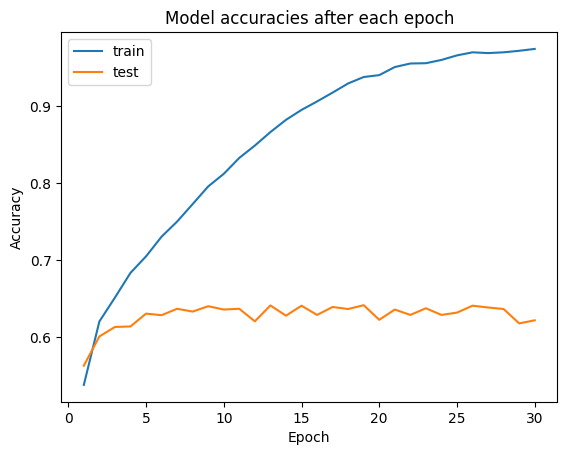

In [21]:
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

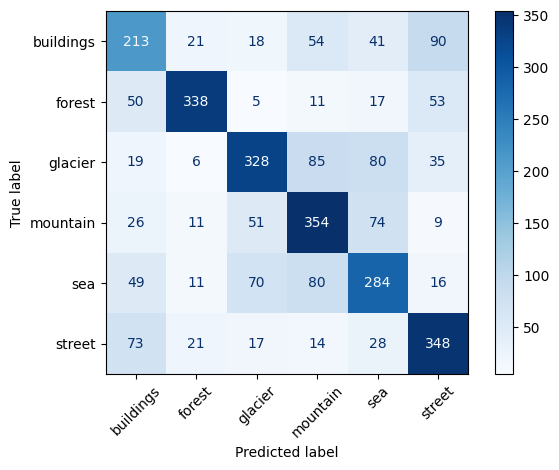

In [22]:
#Confusion matrix for final epoch
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
disp.plot(xticks_rotation=45,cmap="Blues")
plt.tight_layout()
plt.show()

---
Additional starter neural networks to consider...
---

In [25]:
# ============================================
# Step 3: Convolutional Neural Network (CNN)
# ============================================
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    """
    SimpleCNN for RGB images.
    - 2 Conv2d layers (with ReLU + MaxPool)
    - 2-layer MLP head
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()

        # Feature extractor: keep it small & fast for Kaggle
        self.conv_layers = nn.Sequential(
            # Input: [B, 3, 150, 150]
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # -> [B, 32, 150, 150]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> [B, 32, 75, 75]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [B, 64, 75, 75]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> [B, 64, 37, 37]
        )

        # Make the spatial size fixed before the MLP (no fragile hard-coding)
        self.spatial_pool = nn.AdaptiveAvgPool2d((7, 7))  # -> [B, 64, 7, 7]

        self.flatten = nn.Flatten()                       # -> [B, 64*7*7]
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)                   # e.g., 6 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.spatial_pool(x)
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x

In [26]:
# ============================================
# Step 4: training / testing loops 
# ============================================
import torch

def train_loop(dataloader, model, loss_fn, optimizer, device):
    """
    Executes one full training epoch for the given CNN model on the BFGMSS image dataset.

    The DataLoader should yield batches of (image_tensor, label), where:
      - image_tensor is a batch of transformed BFGMSS images
      - label is a batch of integer class indices (0..number_of_classes-1)

    Steps:
      - Move inputs and labels to `device`
      - Forward pass to compute predictions and loss
      - Backpropagation and optimizer step
      - Track average loss and accuracy over the epoch

    Returns:
        (avg_loss, accuracy_percent)
    """
    model.train()
    size = len(dataloader.dataset)
    train_loss, correct = 0.0, 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = train_loss / len(dataloader)
    accuracy = 100.0 * correct / size
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn, device):
    """
    Evaluates the CNN model on the BFGMSS test/validation set.

    Runs a forward pass over all batches with no gradient computation and
    reports average loss and overall accuracy.

    Returns:
        (avg_loss, accuracy_percent)
    """
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = test_loss / num_batches
    accuracy = 100.0 * correct / size
    print(f"Test Error:\n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f}\n")
    return avg_loss, accuracy

In [34]:
# =================================================
# Step 5: fine-tuning block (Kaggle-ready, BFGMSS)
# =================================================
from torch.utils.data import DataLoader
from torch import nn
import time

cnn_model = SimpleCNN().to(device)

learning_rate  = 0.001
batch_size_val = 64
epochs         = 30

loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size_val, shuffle=False)

train_losses   = []
test_losses    = []
train_accuracy = []
test_accuracy  = []

start_time = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    avg_train_loss, train_acc = train_loop(
        train_dataloader, cnn_model, loss_fn, optimizer, device
    )
    avg_test_loss, test_acc = test_loop(
        test_dataloader, cnn_model, loss_fn, device
    )

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

print("Done!")

elapsed = time.time() - start_time
print("Total execution time: %.3f sec" % elapsed)
print("Total execution time: %.3f hrs" % (elapsed / 3600.0))

print(f"{cnn_model.__class__.__name__} model has been trained!")

Epoch 1
-------------------------------
loss: 2.320299  [   64/14034]
loss: 2.126479  [ 6464/14034]
loss: 1.982878  [12864/14034]
Test Error:
 Accuracy: 29.1%, Avg loss: 1.935381

Epoch 2
-------------------------------
loss: 1.925209  [   64/14034]
loss: 1.758004  [ 6464/14034]
loss: 1.696528  [12864/14034]
Test Error:
 Accuracy: 40.8%, Avg loss: 1.650954

Epoch 3
-------------------------------
loss: 1.678624  [   64/14034]
loss: 1.584993  [ 6464/14034]
loss: 1.562063  [12864/14034]
Test Error:
 Accuracy: 44.8%, Avg loss: 1.487258

Epoch 4
-------------------------------
loss: 1.454637  [   64/14034]
loss: 1.444111  [ 6464/14034]
loss: 1.323890  [12864/14034]
Test Error:
 Accuracy: 46.4%, Avg loss: 1.398073

Epoch 5
-------------------------------
loss: 1.330256  [   64/14034]
loss: 1.291136  [ 6464/14034]
loss: 1.443890  [12864/14034]
Test Error:
 Accuracy: 49.2%, Avg loss: 1.351230

Epoch 6
-------------------------------
loss: 1.191938  [   64/14034]
loss: 1.515033  [ 6464/14034]


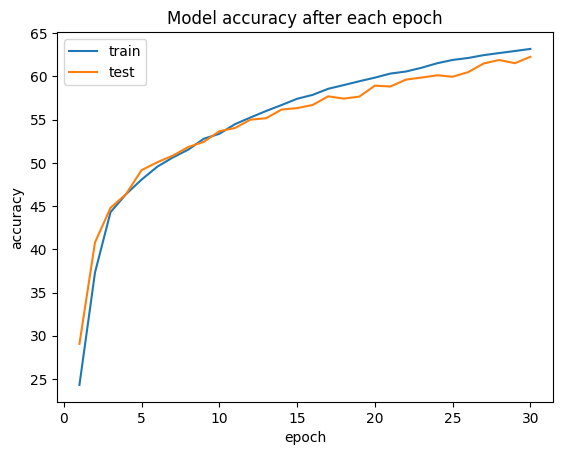

In [38]:
plt.plot(range(1,epochs+1), train_accuracy)
plt.plot(range(1,epochs+1), test_accuracy)
plt.title('Model accuracy after each epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

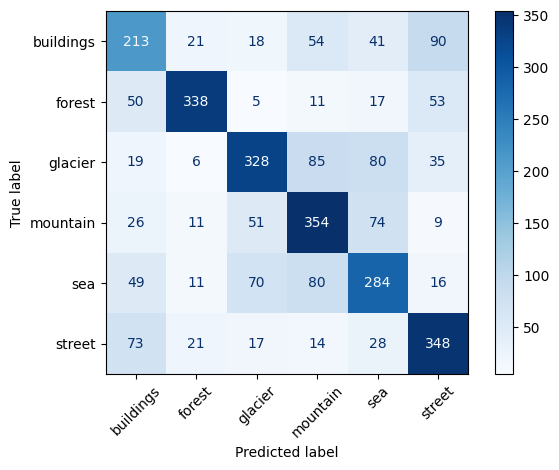

In [39]:
#Confusion matrix for final epoch
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
disp.plot(xticks_rotation=45,cmap="Blues")
plt.tight_layout()
plt.show()

In [42]:
# ============================================
# Step 3: fine-tuned AlexNet model
# ============================================
class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1 if pretrained else None)

        self.features = net.features
        self.avgpool  = net.avgpool

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)          
        x = self.avgpool(x)           
        x = torch.flatten(x, 1)       
        x = self.classifier(x)       
        return x


In [43]:
# ============================================
# Step 4: training / testing loops 
# ============================================
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            running_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.append(pred.argmax(1).cpu())
            all_labels.append(y.cpu())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, conf_matrix

In [47]:
# =================================================
# Step 5: fine-tuning block (Kaggle-ready, BFGMSS)
# =================================================
cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)

learning_rate  = 1e-4
batch_size_val = 32
epochs         = 30

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax   = nn.Softmax(dim=1)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size_val,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size_val,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
)

train_losses      = []
test_losses       = []
train_accuracies  = []
test_accuracies   = []

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy = train_loop(
        train_dataloader, cnn_model, loss_fn, optimizer
    )
    avg_test_loss, test_accuracy, conf_matrix_test = test_loop(
        test_dataloader, cnn_model, loss_fn
    )

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}")
    print(f"Test  loss: {avg_test_loss:.4f}, Test  acc: {test_accuracy:.4f}")

print("AlexNet model has been fine-tuned!")
total_time_sec = time.time() - start_time
print("Total fine-tuning time: %.3f sec" % total_time_sec)
print("Total fine-tuning time: %.3f hrs" % (total_time_sec / 3600.0))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

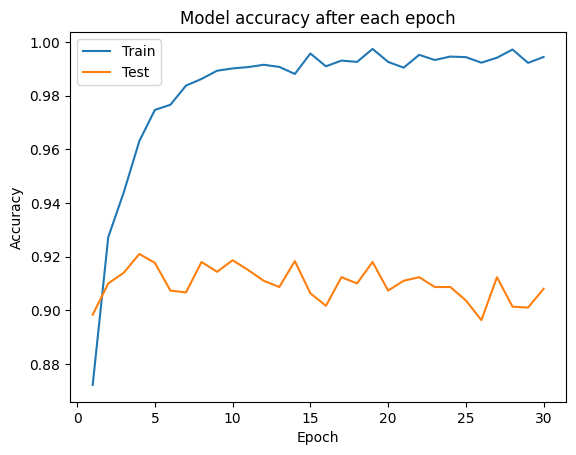

In [48]:
plt.plot(range(1, epochs+1), train_accuracies)
plt.plot(range(1, epochs+1), test_accuracies)
plt.title('Model accuracy after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

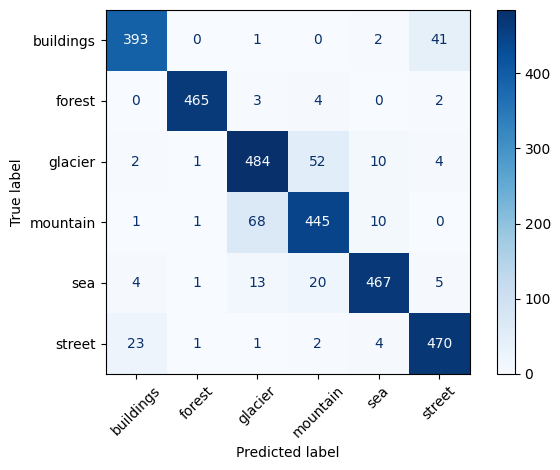

In [49]:
#Confusion matrix for final epoch
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
disp.plot(xticks_rotation=45,cmap="Blues")
plt.tight_layout()
plt.show()

# **Problem:**
For Project 2, we are going to train three deep neural networks: first, a multilayer perceptron (MLP), second a convolutional neural network (CNN), and lastly a fine-tuned AlexNet model for an image recognition task. The problem we will be solving is how accurate our MLP, CNN and fine-tuned AlexNet networks are at image recognition, with classifying an image into one of the 6 classes in the bfgmss dataset.


# **Research:**

**Multilayer Perceptron (MLP):**

For the MLP Network models, I chose a simple fully connected structure and then tuned the training setup.

Structure: I used 150×150 RGB input images, which are first reduced using an Adaptive Average Pooling layer to 32×32 resolution. This produces a flattened input size of 32×32×3 = 3072 features. The network contains two hidden layers: Hidden Layer 1 with 512 units and Hidden Layer 2 with 256 units. Lastly, the output layer has 6 units, one for each class in the bfgmss dataset (buildings, forest, glacier, mountain, sea, and street). This structure is used for all of my models and is based upon the MLB Network we used in class, but to fit the bfgmss dataset.

Epoch tuning: I trained the MLP Network three different times with epochs starting at 10 and increasing by 10 each time. After this, I monitored the training vs test accuracy curves as well as a confusion matrix. Below is the general results of each model before my overall analysis.

**MLP Model 1 (10 Epochs):**

MLP Performance:
Test loss: 1.0469
Test accuracy: 63.67%

MLP Accuracy Graph:

MLP Confusion Matrix:

**MLP Model 2 (20 Epochs):**

MLP Performance:
Test loss: 1.4614
Test accuracy: 64.23%

MLP Accuracy Graph:

MLP Confusion Matrix:

**MLP Model 3 (30 Epochs):**

MLP Performance:
Test loss: 2.0071
Test accuracy: 62.17%

MLP Accuracy Graph:

MLP Confusion Matrix:

**Convolutional Neural Network (CNN):**

For the CNN Network, I tuned the convolutional structure and the number of training epochs, again using the training vs. test accuracy curves to decide when to stop and see the appropriate number of epochs that best suits the model.

Structure:
My CNN Network has two Conv layers, a Flatten layer, two Fully connected (Dense) layers, and lastly an Output layer: 6 units. This is based upon the CNN Network we used in class, but to fit the bfgmss dataset.

Epoch tuning: I trained the CNN Network three different times with epochs starting at 10 and increasing by 10 each time. After this, I monitored the training vs test accuracy curves as well as a confusion matrix. Below is the general results of each model before my overall analysis.

**CNN Model 1 (10 Epochs):**

CNN Performance:
Test loss: 1.225311
Test accuracy: 53.1%

CNN Accuracy Graph:

CNN Confusion Matrix:

**CNN Model 2 (20 Epochs):**

CNN Performance:
Test loss: 1.098358
Test accuracy: 58.5%

CNN Accuracy Graph:

CNN Confusion Matrix:

**CNN Model 3 (30 Epochs):**

CNN Performance:
Test loss: 0.993810
Test accuracy: 61.5%

CNN Accuracy Graph:

CNN Confusion Matrix:

**fine-tuned AlexNet model:**

For the fine-tuned AlexNet model, I used a pretrained ImageNet AlexNet architecture and retrained the classifier layers on the bfgmss dataset. I used the training vs. test loss and accuracy curves to decide when to stop and see the appropriate number of epochs that best suits the model.

Structure:
My fine-tuned AlexNet model keeps the original pretrained convolutional feature extractor from AlexNet, including all convolution, ReLU, and max-pooling layers, along with the built-in spatial average pooling layer. Following this, I replaced AlexNet's original fully connected classifier with a smaller, dataset-specific head consisting of a flatten layer, a fully connected layer with 128 units, ReLU activation, dropout for regularization, and finally an Output layer with 6 units, one for each class in the bfgmss dataset. This was based upon the fine-tuned AlexNet model we used in class but to fit the size and characteristics of the bfgmssdataset.

Epoch tuning: I trained the fine-tuned AlexNet model three different times with epochs starting at 10 and increasing by 10 each time. After this, I monitored the training vs test accuracy curves as well as a confusion matrix. Below is the general results of each model before my overall analysis.

**fine-tuned AlexNet Model 1 (10 Epochs):**

fine-tuned AlexNet Performance:
Test loss: 0.3988
Test accuracy: 90.3%

fine-tuned AlexNet Accuracy Graph:

fine-tuned AlexNet Confusion Matrix:

**fine-tuned AlexNet Model 2 (20 Epochs):**

fine-tuned AlexNet Performance:
Test loss: 0.4637
Test accuracy: 90.9%

fine-tuned AlexNet Accuracy Graph:

fine-tuned AlexNet Confusion Matrix:

**fine-tuned AlexNet Model 3 (30 Epochs):**

fine-tuned AlexNet Performance:
Test loss: 0.5554
Test accuracy: 90.8%

fine-tuned AlexNet Accuracy Graph:

fine-tuned AlexNet Confusion Matrix:

# **Analysis:**

Note: Before I go over my findings, I want to first share an issue that will affect the analysis. The issue I have is that my accuracy graphs and confusion matrices are on a Google document because they would not upload to Kaggle. On Blackboard and this Kaggle Notebook, I attached the Google document showing my results for the nine different models I ran.

Generall: For this project, I trained three different models, MLP, CNN and fine-tuned AlexNet, all on the same bfgmss six-class image dataset. After I trained all these models and compared what happened at the number of epochs (10,20,30). My attached Google Document shows the final test accuracy graphs and also confusion matrices for each model. In this analysis portion, I will explain all my findings from this project, but first wanted to provide general information.

What is AlexNet: AlexNet is a deep convolutional neural network that stacks convolutional and pooling layers to learn visual features, which is followed by fully connected layers that do the final classification. In this project, with a pretrained AlexNet I kept the convolutional feature extractor and average-pooling layers and replaced the classifier with a head that outputs 6 one for each class in the bfgmss dataset. After I fine-tuned this model on my data.


**Overall comparison of models:**

MLP: Across all epochs the MLP's test accuracy stayed in the low to mid 60% range.

MLP 1 (10 epochs): test accuracy 63.67%, loss 1.0469

MLP 2 (20 epochs): test accuracy 64.23%, loss 1.4614

MLP 3 (30 epochs): test accuracy 62.17%, loss 2.0071

From looking at the accuracy graphs, they show the training accuracy climbs steadily toward .8-.95. While test accuracy plateaus around 62%-64% and gets slightly lower for the 30-epoch model. I believe there is overfitting here because the MLP gets very good at fitting the training set. But its generalization to the testing images stops improving and even eventually gets worse as it memorizes noise instead of further learning.

The MLP Confusion matrices show the same results. Overall, all the matrices show that the diagonal is pretty strong but decreases with every 10 added epochs. Also, there are noticeable misclassifications, mainly between similar classes such as building vs street.

CNN: Starts off weaker than the MLP but improves from extra epochs. Models run around 53%-63% test accuracy.

CNN 1 (10 epochs): test accuracy 53.1%, loss 1.225311

CNN 2 (20 epochs): test accuracy 58.5%, loss 1.098358

CNN 3 (30 epochs): test accuracy 61.5%, loss 0.993810

Unlike the MLP models, both the training and test accuracies on the accuracy graphs increased as I added more epochs for the CNN models. Furthermore, they stayed fairly close together. These CNN models are steadily getting better on the test set and might improve further with even more than 30 epochs that I could have tested on.

The CNN confusion matrices are the same across all different epoch models and are not that good. Same as MLP, there are also misclassifications.

fine-tuned AlexNet: Best neural network compared to the MLP and CNN models. 

AlexNet 1 (10 epochs): test accuracy 90.3%, loss 0.3988

AlexNet 2 (20 epochs): test accuracy 90.9%, loss 0.4637

AlexNet 3 (30 epochs): test accuracy 90.8%, loss 0.5554

All three models test accuracy is around 90%-91% which is far above the MLP and CNN. The accuracy curves show the training accuracy quickly reaches .99 while the test accuracy peaks around .91 and stays around that level even as training accuracy continues to move up. This could indicate a chance for some overfitting, but this isnt a concern for me, especially since the model performed so well.

The confusion matrices show very strong diagonals. Stronger then the MLP and CNN.

**Which model performed best, and why?**

The fine-tuned AlexNet model with 20 epochs performed the best out of all other models. Its test accuracy was 90.9% which is roughly 30%-40% higher than the MLP and CNN models. Fine-tuned AlexNet is the best because it brings in pretrained convolutional features, which help learn on massive datasets, and help recognize visual patterns. The classifier head only had to learn the six bfgmss classes, which is an easier problem for a fine-tuned AlexNet to do than learning from scratch like other models. This is why fine-tuned AlexNet reached higher accuracies quickly.

**Which model struggled, and why?**

The model that struggled the most was the CNN model, especially the CNN model with 10 and 20 epochs. The test accuracies through these 10,20, and 30 epoch models started at 53.1% and only ever reached 61.5% in the 30 epoch CNN model. This model struggled the most because CNN has fewer layers and parameters, so it cannot learn deep or complex features. CNN also doesn't benefit from pretrained weights, so it has to find patterns from the dataset.

**What insights or recommendations do I have?**

An insight I have is how powerful pretrained convolutional features are, especially when a dataset is not huge. With the CNN/MLP, the accuracy was only around 50%-60%, but the AlexNet model was around 90%, showing how powerful it is. For future projects similar to this, if you want the best results immediately, AlexNet is by far the best choice.

**What I found interesting or unexpected?**

Even though the AlexNet model did so great, something I found interesting was that as more epochs were added, the AlexNet model did get worse. Once AlexNet hit around 90% test accuracy with 20 epochs, as I added more epochs, it mainly changed the test loss and didn't improve the model's accuracy. This was an interesting finding and shows that there is an ideal spot in fine-tuning when you've adapted enough but are not over-specialized to the training set.

**Conclusion:**

Overall, my experiments show the fine-tuned AlexNet is by far the best overall network for this project, followed by MLP and lastly CNN. Overall, my best model was the fine-tuned AlexNet with 20 epochs. My results show the importance of model choice and learning when working with image data. Furthermore, my results show how accuracy graphs and confusion matrices can guide decisions and give insights with tuning and training.


**How I choose my tuning parameters?**

For this project, I tuned the number of training epochs to 10, 20, and 30. I did this for two reasons. My first reason was that I wanted all nine models to be trained the same way. My second reason was to watch the training vs. test accuracy graphs and choose a setting where the test curve stopped improving or started flattening out. For the MLP, the test accuracy plateaued around 20 epochs. For the CNN, both training and testing kept improving with 30 epochs. Lastly, for AlexNet, test accuracy was the best at around 20 epochs. If I had more time I would potentially run more models for CNN and also my next tuning steps would be to change the learning rates.

# **Bumps in the Road:**

While completing this project, I didn't have a ton of challenges that prevented me from completing the project. But I did come across three challenges that made me have to allocate more time than expected. The first challenge was finishing the code for this project. The second challenge I had was running all my models for CNN, MLP, and fine-tuned AlexNet. The third challenge I had was figuring out how to implement the confusion matrix code. For the first problem, coding took longer than expected because for the CNN and the fine-tuned AlexNet code I had to complete it. To do this, I had to go back to old notebooks and in-class work to use the code, but then implement it correctly in the bfgmss dataset, which made me allocate more time than expected. The second challenge I ran into was running my three different models for the CNN, MLP, and fine-tuned AlexNet. This was a challenge I faced because testing these models took upwards of 20 minutes at a time. To solve this, I could have been more efficient by playing around with the code to make the models run faster, but I decided not to because I had time to wait. In the future, I would adjust this. Lastly, the third challenge I ran into was implementing the confusion matrix code for the CNN and fine-tuned AlexNet. This was an issue for me because I couldn't figure out how to properly add the confusion matrix code to both the CNN and fine-tuned AlexNet. What I did to fix this problem was copy the code from the MLP confusion matrix to the CNN and fine-tuned AlexNet sections. Overall, these were the three main challenges I faced in this project.

**Google Document Link:**
https://docs.google.com/document/d/1Xlp15kniIv6F6yeWr5icgPvE01F4QQfAbljV4ZCzg5A/edit?usp=sharing
